In [182]:
import GamificationRL
from collections import defaultdict
import gymnasium as gym
from GamificationRL.envs.gamification_elements import *
import random
from itertools import permutations  
from adaptive_agent import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from hexad_answer_bot import *
plt.rcParams["figure.figsize"]=(10,7)
import pandas as pd
hexad_types_full = ["Player", "Achiever", "Philanthropist", "Disruptor", "Socializer", "Free Spirit"]
import logging
gym.logger.setLevel(logging.CRITICAL)

#### Environment Init

In [183]:
corr_g_e=list(corr_gamification_elements.values())
sample_g_e=list(sample_gamification_elements.values())
g_e=sample_g_e[1::2]
colors=['violet','purple','red','sienna',
        'darkorange','burlywood','gold','darkgoldenrod',
        'olivedrab','lawngreen','deepskyblue','steelblue']
ge2c={"Nothing":'black'}
for i in range(len(g_e)):
    ge2c[g_e[i].name]=colors[i]
hexad=hexad_load_dict(pl=2,ach=5,ph=4,dis=0.5,s=1,fs=3).load_dict
#hexad=hexad_load_dict(pl=3,ach=3,ph=3,dis=3,s=3,fs=3).load_dict
fatigue_penalty=0.05
fatigue_replenishment=0.01
nothing_reward=75
ranges=(1.0,1.3,1.7)
increase=(0.2,0.1,0.05)
decrease=(0.1,0.1,0.1)
pref_min=0.2
seed=10101

In [184]:
env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',
               hexad_load=hexad,
               gamification_elements=g_e,
               use_fatigue=True,
               individual_modifications=None,
               repetition_penalty=(400,800),
               nothing_reward=nothing_reward,
               fatigue_reduction=fatigue_penalty,
               fatigue_replenish=fatigue_replenishment,
               pref_ranges=ranges,
               pref_increase=increase,
               pref_decrease=decrease,
               pref_min=pref_min,
               seed=seed
               )
obs,_=env.reset()

#### Answer Bot Init

In [185]:
uncertainty=.1
divisor=5.5
starting_threshold=.1
gain_modifier=0.02
amount=1
ht=copy.deepcopy(hexad)
#ht=hexad_load_dict(pl=2,ach=5,ph=4,dis=0.5,s=1,fs=3).load_dict

In [186]:
bot = ScoreChangeBot(
        hexad_types=copy.deepcopy(ht),
        uncertainty= uncertainty,
        divisor=divisor,
        starting_change_threshold=starting_threshold,
        change_gain_modifier=gain_modifier,
        change_amount=amount,
        seed=seed,
    )

#### Agent init

In [187]:
#general parameters
learn_rate=0.002
discount_factor=0.7

In [188]:
#Fatigue-aware parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(10000)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [189]:
fa_agent=FatigueAwareAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )
train_error=fa_agent.train(env=env,iterations=training_iterations,trunc_error=True)

In [190]:
#Epsilon agent parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(10000)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [191]:
e_agent=EpsilonAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )
train_error=e_agent.train(env=env,iterations=training_iterations,trunc_error=True)

In [192]:

basic_agent=BasicAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   )
train_error=basic_agent.train(env=env,iterations=training_iterations,trunc_error=True)


In [193]:
#RandomBestOfX parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(10000)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*4/5000)
x=3

In [194]:

boX_agent=RandomBestOfX(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   X=x
                   )

train_error=boX_agent.train(env=env,iterations=training_iterations,trunc_error=True)


In [195]:
agents={"Basic":basic_agent,"Epsilon":e_agent,"BestOfX":boX_agent,"FatigueAware":fa_agent}
init_q_values={}
for name,agent in agents.items():
    init_q_values[name]=copy.deepcopy(agent.q_values)

#### Testing Functions

In [196]:

def test_env_agent(env,agent,answer_bot,test_iterations,retrain_iterations,random_retrain,training_lr):
    rewards=[]
    choices=[]
    best=[]
    agent_error=[]
    actions=defaultdict(lambda:{'x':[],'y':[]})
    obs,info=env.reset()
    for i in tqdm(range(test_iterations)):
        best.append(env.get_best_action())
        act=agent.get_action(obs,avoid_reps=True)
        h_type=env.ge[env.action_to_ge[act]].type
        answer,_=answer_bot.get_answer(h_type)
        choice,reward,new_obs,info,error=agent\
            .step_and_update(env=env,
                            obs=obs,
                            answer=answer,
                            retrain_iterations=retrain_iterations,
                            learning_rate=training_lr,
                            random_retrain=random_retrain,
                            act=act)
        choices.append(choice)
        rewards.append(reward)
        agent_error.append(error)
        actions[choice]['x'].append(i)
        actions[choice]['y'].append(reward)
        obs=new_obs
    return rewards,choices,best,agent_error,actions,(obs,info)

In [197]:
def plot_actions(actions,env,title=None,f=1):
    typ='pl'
    fig=plt.figure(f,figsize=(12,7))
    fig.suptitle(title)
    for i,_ in sorted(actions.items()):
        name=env.action_to_ge[i]
        hex_type=env.ge[name].type
        if hex_type!=None:
            plt.figure(f)
            type_index=hexad_types.index(env.ge[name].type)+1
        else:
            plt.figure(f+1)
        plt.subplot(3,2,type_index)
        plt.ylim(0,1000)
        plt.xlim(0,1000)
        plt.scatter(actions[i]['x'],actions[i]['y'],label=name,s=2)
        ax=plt.gca()
        ax.legend()
    plt.figure(f+2)
    fig.suptitle(title)
    for i in actions:
        plt.scatter(actions[i]['x'],actions[i]['y'],label=env.action_to_ge[i],s=5)
        ax=plt.gca()
        ax.legend()

In [198]:
def get_stats(actions,best,choices):
    type_stats=defaultdict(lambda:0)
    for i in actions:
        try:
            type_stats[sample_gamification_elements[env.action_to_ge[i]].type]+=len(actions[i]['x'])
        except KeyError:
            type_stats['None']+=len(actions[i]['x'])
    s=0
    for i in range(len(best)):
        if best[i][1]==choices[i][1]:
            s+=1
    diff=[best[i][1]-choices[i][1] for i in range(len(choices))]
    diff=np.array(diff)
    diff=diff[diff>0.01]
    actual=pd.Series([env.action_to_ge[item[0]] for item in best],name="Actual Best")
    pred = pd.Series([env.action_to_ge[item[0]] for item in b],name="Predicted Best")
    conf_matrix=pd.crosstab(actual,pred,margins=True)
    return type_stats,s/len(best),diff,conf_matrix

#### Hyperparameter tuning

##### Retrains per iteration

In [199]:
tests=500
retrains=1000
retrain_learn_rate=0.3
accs={}
a_e={}
d_b={}
j=0
test_range = [1,100,250,500,750,1000,1500,2000,2500,3000,4000,8000]
for name,agent in agents.items():
    print(name)
    random_retrain=(name=="Basic" or name=='BestOfX')
    accs[name]={'avg':[],'std':[]}
    a_e[name]={'avg':[],'std':[]}
    d_b[name]={'avg':[],'std':[]}
    for retrains in tqdm(test_range):
        print(f"Current test: retrains={retrains}")
        print("Iteration: ",end='')
        accuracy=[]
        diff_from_best=[]
        agent_error=[]
        for j in range(4):
            print(f"{j+1}, ",end='')
            r,c,b,e,a,_=test_env_agent(env,agent,
                        answer_bot=bot,
                        test_iterations=tests,
                        retrain_iterations=retrains,
                        random_retrain=random_retrain,
                        training_lr=retrain_learn_rate)
            t,acc,diff,conf_matrix = get_stats(a,b,[*zip(c,r)])
            accuracy.append(acc)
            diff_from_best.extend((diff))
            agent_error.extend((e))
            agent.reset()
            agent.train(env=env,iterations=training_iterations,trunc_error=True)
            bot = ScoreChangeBot(
                hexad_types=ht,
                uncertainty= uncertainty,
                divisor=divisor,
                starting_change_threshold=starting_threshold,
                change_gain_modifier=gain_modifier,
                change_amount=amount,
                seed=seed,
            )
        print()  
        accs[name]['avg'].append(np.average(accuracy))
        accs[name]['std'].append(np.std(accuracy))
        a_e[name]['avg'].append(np.average(agent_error))
        a_e[name]['std'].append(np.std(agent_error))
        d_b[name]['avg'].append(np.average(diff_from_best))
        d_b[name]['std'].append(np.std(diff_from_best))

Basic


  0%|          | 0/12 [00:00<?, ?it/s]

Current test: retrains=1
Iteration: 1, 

100%|██████████| 500/500 [00:00<00:00, 10240.35it/s]


2, 

100%|██████████| 500/500 [00:00<00:00, 11222.04it/s]


3, 

100%|██████████| 500/500 [00:00<00:00, 11969.16it/s]

4, 


  8%|▊         | 1/12 [00:00<00:09,  1.19it/s]


Current test: retrains=100
Iteration: 1, 

100%|██████████| 500/500 [00:00<00:00, 744.46it/s]


2, 

100%|██████████| 500/500 [00:00<00:00, 690.03it/s]


3, 

100%|██████████| 500/500 [00:00<00:00, 807.65it/s]


4, 

 17%|█▋        | 2/12 [00:04<00:23,  2.34s/it]


Current test: retrains=250
Iteration: 1, 

100%|██████████| 500/500 [00:01<00:00, 319.76it/s]


2, 

100%|██████████| 500/500 [00:01<00:00, 323.53it/s]


3, 

100%|██████████| 500/500 [00:01<00:00, 311.18it/s]


4, 

 25%|██▌       | 3/12 [00:11<00:39,  4.43s/it]


Current test: retrains=500
Iteration: 1, 

100%|██████████| 500/500 [00:03<00:00, 159.12it/s]


2, 

100%|██████████| 500/500 [00:03<00:00, 156.08it/s]


3, 

100%|██████████| 500/500 [00:03<00:00, 155.73it/s]


4, 

 33%|███▎      | 4/12 [00:24<01:03,  7.98s/it]


Current test: retrains=750
Iteration: 1, 

100%|██████████| 500/500 [00:04<00:00, 102.49it/s]


2, 

100%|██████████| 500/500 [00:04<00:00, 102.45it/s]


3, 

100%|██████████| 500/500 [00:04<00:00, 105.25it/s]


4, 

 42%|████▏     | 5/12 [00:53<01:49, 15.69s/it]


Current test: retrains=1000
Iteration: 1, 

100%|██████████| 500/500 [00:21<00:00, 22.87it/s]


2, 

100%|██████████| 500/500 [00:22<00:00, 22.71it/s]


3, 

100%|██████████| 500/500 [00:21<00:00, 22.76it/s]


4, 

 50%|█████     | 6/12 [02:24<04:06, 41.10s/it]


Current test: retrains=1500
Iteration: 1, 

100%|██████████| 500/500 [00:22<00:00, 22.50it/s]


2, 

100%|██████████| 500/500 [00:09<00:00, 52.09it/s]


3, 

100%|██████████| 500/500 [00:09<00:00, 52.33it/s]


4, 

 58%|█████▊    | 7/12 [03:15<03:42, 44.52s/it]


Current test: retrains=2000
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 38.46it/s]


2, 

100%|██████████| 500/500 [00:12<00:00, 38.73it/s]


3, 

100%|██████████| 500/500 [00:12<00:00, 39.12it/s]


4, 

 67%|██████▋   | 8/12 [04:08<03:08, 47.01s/it]


Current test: retrains=2500
Iteration: 1, 

100%|██████████| 500/500 [00:16<00:00, 31.18it/s]


2, 

100%|██████████| 500/500 [00:16<00:00, 31.06it/s]


3, 

100%|██████████| 500/500 [00:15<00:00, 31.54it/s]


4, 

 75%|███████▌  | 9/12 [05:12<02:37, 52.51s/it]


Current test: retrains=3000
Iteration: 1, 

100%|██████████| 500/500 [00:19<00:00, 26.12it/s]


2, 

100%|██████████| 500/500 [00:19<00:00, 26.29it/s]


3, 

100%|██████████| 500/500 [00:19<00:00, 26.14it/s]


4, 

 83%|████████▎ | 10/12 [08:07<03:00, 90.35s/it]


Current test: retrains=4000
Iteration: 1, 

100%|██████████| 500/500 [03:17<00:00,  2.53it/s]


2, 

100%|██████████| 500/500 [00:25<00:00, 19.39it/s]


3, 

100%|██████████| 500/500 [00:26<00:00, 18.79it/s]


4, 

 92%|█████████▏| 11/12 [12:43<02:27, 147.09s/it]


Current test: retrains=8000
Iteration: 1, 

100%|██████████| 500/500 [01:07<00:00,  7.42it/s]


2, 

100%|██████████| 500/500 [00:53<00:00,  9.40it/s]


3, 

100%|██████████| 500/500 [00:42<00:00, 11.71it/s]


4, 

100%|██████████| 12/12 [16:09<00:00, 80.76s/it] 



Epsilon


  0%|          | 0/12 [00:00<?, ?it/s]

Current test: retrains=1
Iteration: 1, 

100%|██████████| 500/500 [00:00<00:00, 13715.48it/s]

2, 


100%|██████████| 500/500 [00:00<00:00, 13575.38it/s]


3, 

100%|██████████| 500/500 [00:00<00:00, 12956.74it/s]


4, 

  8%|▊         | 1/12 [00:00<00:08,  1.35it/s]


Current test: retrains=100
Iteration: 1, 

100%|██████████| 500/500 [00:00<00:00, 683.15it/s]


2, 

100%|██████████| 500/500 [00:00<00:00, 742.44it/s]


3, 

100%|██████████| 500/500 [00:00<00:00, 681.30it/s]


4, 

 17%|█▋        | 2/12 [00:04<00:22,  2.29s/it]


Current test: retrains=250
Iteration: 1, 

100%|██████████| 500/500 [00:01<00:00, 295.97it/s]


2, 

100%|██████████| 500/500 [00:01<00:00, 283.64it/s]


3, 

100%|██████████| 500/500 [00:01<00:00, 297.04it/s]


4, 

 25%|██▌       | 3/12 [00:11<00:41,  4.63s/it]


Current test: retrains=500
Iteration: 1, 

100%|██████████| 500/500 [00:03<00:00, 156.09it/s]


2, 

100%|██████████| 500/500 [00:03<00:00, 149.56it/s]


3, 

100%|██████████| 500/500 [00:03<00:00, 142.58it/s]


4, 

 33%|███▎      | 4/12 [00:25<01:06,  8.34s/it]


Current test: retrains=750
Iteration: 1, 

100%|██████████| 500/500 [00:05<00:00, 99.69it/s]


2, 

100%|██████████| 500/500 [00:04<00:00, 101.96it/s]


3, 

100%|██████████| 500/500 [00:05<00:00, 98.97it/s] 


4, 

 42%|████▏     | 5/12 [00:46<01:29, 12.76s/it]


Current test: retrains=1000
Iteration: 1, 

100%|██████████| 500/500 [00:06<00:00, 73.51it/s]


2, 

100%|██████████| 500/500 [00:07<00:00, 70.32it/s]


3, 

100%|██████████| 500/500 [00:07<00:00, 70.05it/s]


4, 

 50%|█████     | 6/12 [01:14<01:47, 17.94s/it]


Current test: retrains=1500
Iteration: 1, 

100%|██████████| 500/500 [00:14<00:00, 34.94it/s]


2, 

100%|██████████| 500/500 [00:18<00:00, 27.06it/s]


3, 

100%|██████████| 500/500 [00:18<00:00, 26.33it/s]


4, 

 58%|█████▊    | 7/12 [02:25<02:57, 35.49s/it]


Current test: retrains=2000
Iteration: 1, 

100%|██████████| 500/500 [00:25<00:00, 19.71it/s]


2, 

100%|██████████| 500/500 [00:25<00:00, 19.82it/s]


3, 

100%|██████████| 500/500 [00:24<00:00, 20.03it/s]


4, 

 67%|██████▋   | 8/12 [04:07<03:46, 56.61s/it]


Current test: retrains=2500
Iteration: 1, 

100%|██████████| 500/500 [00:31<00:00, 15.93it/s]


2, 

100%|██████████| 500/500 [00:22<00:00, 22.42it/s]


3, 

100%|██████████| 500/500 [00:15<00:00, 32.27it/s]


4, 

 75%|███████▌  | 9/12 [05:33<03:17, 65.74s/it]


Current test: retrains=3000
Iteration: 1, 

100%|██████████| 500/500 [00:38<00:00, 13.14it/s]


2, 

100%|██████████| 500/500 [00:38<00:00, 13.14it/s]


3, 

100%|██████████| 500/500 [00:17<00:00, 28.23it/s]


4, 

 83%|████████▎ | 10/12 [07:26<02:40, 80.21s/it]


Current test: retrains=4000
Iteration: 1, 

100%|██████████| 500/500 [00:23<00:00, 21.06it/s]


2, 

100%|██████████| 500/500 [00:24<00:00, 20.03it/s]


3, 

100%|██████████| 500/500 [00:25<00:00, 19.63it/s]


4, 

 92%|█████████▏| 11/12 [09:05<01:26, 86.18s/it]


Current test: retrains=8000
Iteration: 1, 

100%|██████████| 500/500 [00:49<00:00, 10.02it/s]


2, 

100%|██████████| 500/500 [00:49<00:00, 10.02it/s]


3, 

100%|██████████| 500/500 [01:06<00:00,  7.48it/s]


4, 

100%|██████████| 12/12 [13:23<00:00, 66.94s/it] 



BestOfX


  0%|          | 0/12 [00:00<?, ?it/s]

Current test: retrains=1
Iteration: 1, 

100%|██████████| 500/500 [00:00<00:00, 14243.67it/s]


2, 

100%|██████████| 500/500 [00:00<00:00, 15076.90it/s]


3, 

100%|██████████| 500/500 [00:00<00:00, 15146.48it/s]


4, 

100%|██████████| 500/500 [00:00<00:00, 7498.85it/s]


  8%|▊         | 1/12 [00:00<00:07,  1.46it/s]

Current test: retrains=100
Iteration: 1, 

100%|██████████| 500/500 [00:00<00:00, 948.81it/s]


2, 

100%|██████████| 500/500 [00:00<00:00, 964.02it/s]


3, 

100%|██████████| 500/500 [00:00<00:00, 967.38it/s]


4, 

 17%|█▋        | 2/12 [00:03<00:18,  1.81s/it]


Current test: retrains=250
Iteration: 1, 

100%|██████████| 500/500 [00:01<00:00, 386.32it/s]


2, 

100%|██████████| 500/500 [00:01<00:00, 367.47it/s]


3, 

100%|██████████| 500/500 [00:01<00:00, 375.34it/s]


4, 

 25%|██▌       | 3/12 [00:09<00:32,  3.63s/it]


Current test: retrains=500
Iteration: 1, 

100%|██████████| 500/500 [00:02<00:00, 182.94it/s]


2, 

100%|██████████| 500/500 [00:02<00:00, 180.22it/s]


3, 

100%|██████████| 500/500 [00:02<00:00, 180.02it/s]


4, 

 33%|███▎      | 4/12 [00:20<00:54,  6.81s/it]


Current test: retrains=750
Iteration: 1, 

100%|██████████| 500/500 [00:04<00:00, 118.80it/s]


2, 

100%|██████████| 500/500 [00:05<00:00, 88.55it/s]


3, 

100%|██████████| 500/500 [00:08<00:00, 59.93it/s]


4, 

 42%|████▏     | 5/12 [00:48<01:39, 14.25s/it]


Current test: retrains=1000
Iteration: 1, 

100%|██████████| 500/500 [00:10<00:00, 46.65it/s]


2, 

100%|██████████| 500/500 [00:10<00:00, 48.24it/s]


3, 

100%|██████████| 500/500 [00:10<00:00, 45.88it/s]


4, 

 50%|█████     | 6/12 [01:32<02:26, 24.35s/it]


Current test: retrains=1500
Iteration: 1, 

100%|██████████| 500/500 [00:14<00:00, 33.37it/s]


2, 

100%|██████████| 500/500 [00:16<00:00, 30.29it/s]


3, 

100%|██████████| 500/500 [00:16<00:00, 30.71it/s]


4, 

 58%|█████▊    | 7/12 [02:37<03:08, 37.71s/it]


Current test: retrains=2000
Iteration: 1, 

100%|██████████| 500/500 [00:22<00:00, 22.38it/s]


2, 

100%|██████████| 500/500 [00:16<00:00, 29.92it/s]


3, 

100%|██████████| 500/500 [00:10<00:00, 46.81it/s]


4, 

 67%|██████▋   | 8/12 [03:38<03:00, 45.22s/it]


Current test: retrains=2500
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 36.41it/s]


2, 

100%|██████████| 500/500 [00:16<00:00, 30.75it/s]


3, 

100%|██████████| 500/500 [00:25<00:00, 19.26it/s]


4, 

 75%|███████▌  | 9/12 [05:01<02:51, 57.02s/it]


Current test: retrains=3000
Iteration: 1, 

100%|██████████| 500/500 [00:32<00:00, 15.23it/s]


2, 

100%|██████████| 500/500 [00:32<00:00, 15.18it/s]


3, 

100%|██████████| 500/500 [00:32<00:00, 15.38it/s]


4, 

 83%|████████▎ | 10/12 [07:13<02:40, 80.04s/it]


Current test: retrains=4000
Iteration: 1, 

100%|██████████| 500/500 [00:41<00:00, 11.92it/s]


2, 

100%|██████████| 500/500 [00:42<00:00, 11.87it/s]


3, 

100%|██████████| 500/500 [00:32<00:00, 15.56it/s]


4, 

 92%|█████████▏| 11/12 [09:54<01:44, 104.82s/it]


Current test: retrains=8000
Iteration: 1, 

100%|██████████| 500/500 [01:27<00:00,  5.72it/s]


2, 

100%|██████████| 500/500 [01:23<00:00,  5.98it/s]


3, 

100%|██████████| 500/500 [01:23<00:00,  5.96it/s]


4, 

100%|██████████| 12/12 [15:22<00:00, 76.85s/it] 



FatigueAware


  0%|          | 0/12 [00:00<?, ?it/s]

Current test: retrains=1
Iteration: 1, 

100%|██████████| 500/500 [00:00<00:00, 8462.06it/s]


2, 

100%|██████████| 500/500 [00:00<00:00, 7004.33it/s]


3, 

100%|██████████| 500/500 [00:00<00:00, 7177.31it/s]


4, 

  8%|▊         | 1/12 [00:01<00:13,  1.23s/it]


Current test: retrains=100
Iteration: 1, 

100%|██████████| 500/500 [00:01<00:00, 383.02it/s]


2, 

100%|██████████| 500/500 [00:01<00:00, 322.14it/s]


3, 

100%|██████████| 500/500 [00:01<00:00, 348.89it/s]


4, 

 17%|█▋        | 2/12 [00:08<00:45,  4.59s/it]


Current test: retrains=250
Iteration: 1, 

100%|██████████| 500/500 [00:03<00:00, 141.63it/s]


2, 

100%|██████████| 500/500 [00:03<00:00, 141.13it/s]


3, 

100%|██████████| 500/500 [00:03<00:00, 140.21it/s]


4, 

 25%|██▌       | 3/12 [00:23<01:24,  9.34s/it]


Current test: retrains=500
Iteration: 1, 

100%|██████████| 500/500 [00:06<00:00, 72.49it/s]


2, 

100%|██████████| 500/500 [00:06<00:00, 73.89it/s]


3, 

100%|██████████| 500/500 [00:07<00:00, 69.27it/s]


4, 

 33%|███▎      | 4/12 [00:52<02:17, 17.20s/it]


Current test: retrains=750
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 45.26it/s]


2, 

100%|██████████| 500/500 [00:10<00:00, 46.47it/s]


3, 

100%|██████████| 500/500 [00:10<00:00, 45.58it/s]


4, 

 42%|████▏     | 5/12 [01:36<03:08, 26.93s/it]


Current test: retrains=1000
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 35.79it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 37.71it/s]


3, 

100%|██████████| 500/500 [00:06<00:00, 80.82it/s]


4, 

 50%|█████     | 6/12 [02:17<03:09, 31.61s/it]


Current test: retrains=1500
Iteration: 1, 

100%|██████████| 500/500 [00:10<00:00, 48.13it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 36.53it/s]


3, 

100%|██████████| 500/500 [00:11<00:00, 42.29it/s]


4, 

 58%|█████▊    | 7/12 [03:05<03:05, 37.11s/it]


Current test: retrains=2000
Iteration: 1, 

100%|██████████| 500/500 [00:21<00:00, 23.70it/s]


2, 

100%|██████████| 500/500 [00:26<00:00, 18.74it/s]


3, 

100%|██████████| 500/500 [00:18<00:00, 27.02it/s]


4, 

 67%|██████▋   | 8/12 [04:41<03:42, 55.66s/it]


Current test: retrains=2500
Iteration: 1, 

100%|██████████| 500/500 [00:35<00:00, 14.19it/s]


2, 

100%|██████████| 500/500 [00:33<00:00, 14.89it/s]


3, 

100%|██████████| 500/500 [00:34<00:00, 14.69it/s]


4, 

 75%|███████▌  | 9/12 [06:58<04:03, 81.30s/it]


Current test: retrains=3000
Iteration: 1, 

100%|██████████| 500/500 [00:19<00:00, 25.49it/s]


2, 

100%|██████████| 500/500 [00:21<00:00, 23.21it/s]


3, 

100%|██████████| 500/500 [00:21<00:00, 23.32it/s]


4, 

 83%|████████▎ | 10/12 [08:27<02:46, 83.45s/it]


Current test: retrains=4000
Iteration: 1, 

100%|██████████| 500/500 [00:33<00:00, 14.96it/s]


2, 

100%|██████████| 500/500 [00:33<00:00, 14.90it/s]


3, 

100%|██████████| 500/500 [00:32<00:00, 15.38it/s]


4, 

 92%|█████████▏| 11/12 [10:34<01:37, 97.06s/it]


Current test: retrains=8000
Iteration: 1, 

100%|██████████| 500/500 [00:56<00:00,  8.86it/s]


2, 

100%|██████████| 500/500 [01:12<00:00,  6.94it/s]


3, 

100%|██████████| 500/500 [01:39<00:00,  5.02it/s]


4, 

100%|██████████| 12/12 [16:07<00:00, 80.60s/it] 

In [200]:
acc_diff={}
for name,agent in agents.items():
    acc_diff[name]=[]
    a_d=[]
    prev=0
    for acc in accs[name]['avg']:
        acc_diff[name].append(acc-prev)
        prev=acc

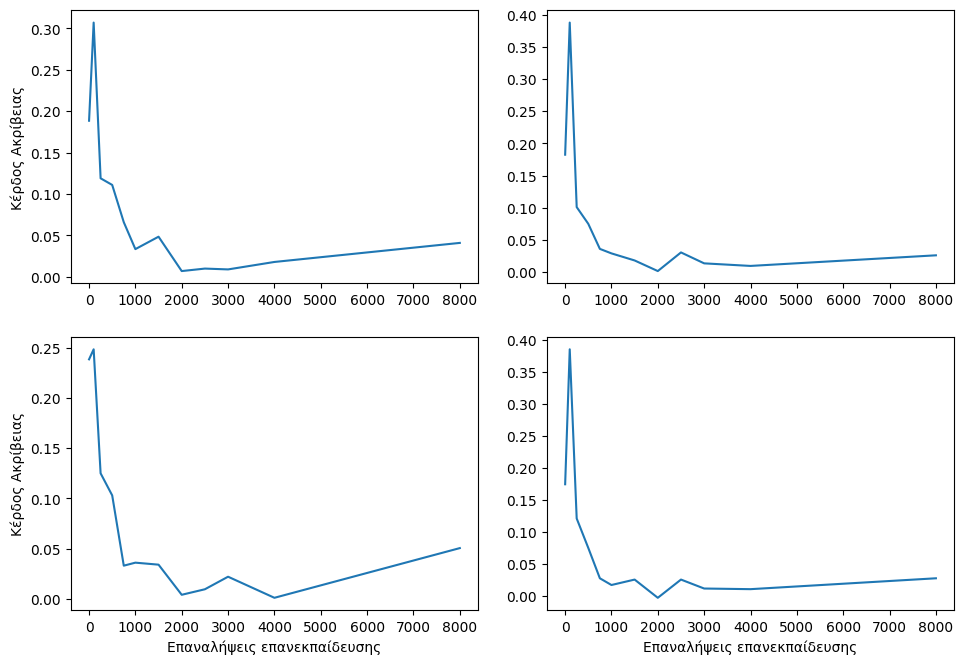

In [201]:
i=1
for name,agent in agents.items():
    plt.figure(1)
    plt.subplot(2,2,i)
    plt.plot(test_range,acc_diff[name])
    plt.tight_layout(pad=2)
    if i in [1,3]:
        plt.ylabel('Κέρδος Ακρίβειας')
    if i in [3,4]:
        plt.xlabel('Επαναλήψεις επανεκπαίδευσης')
    i+=1

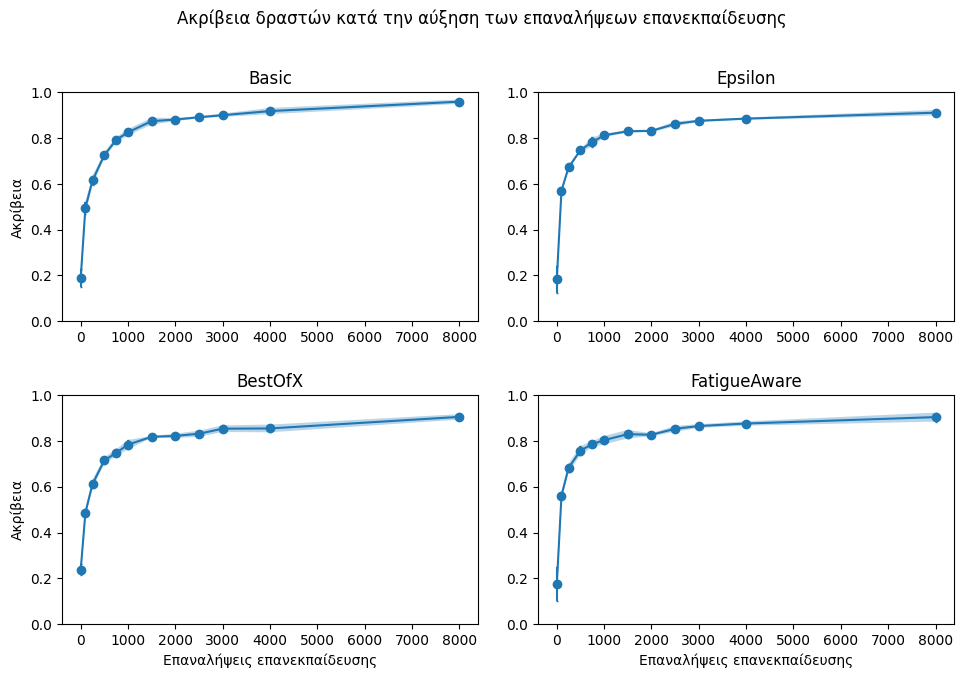

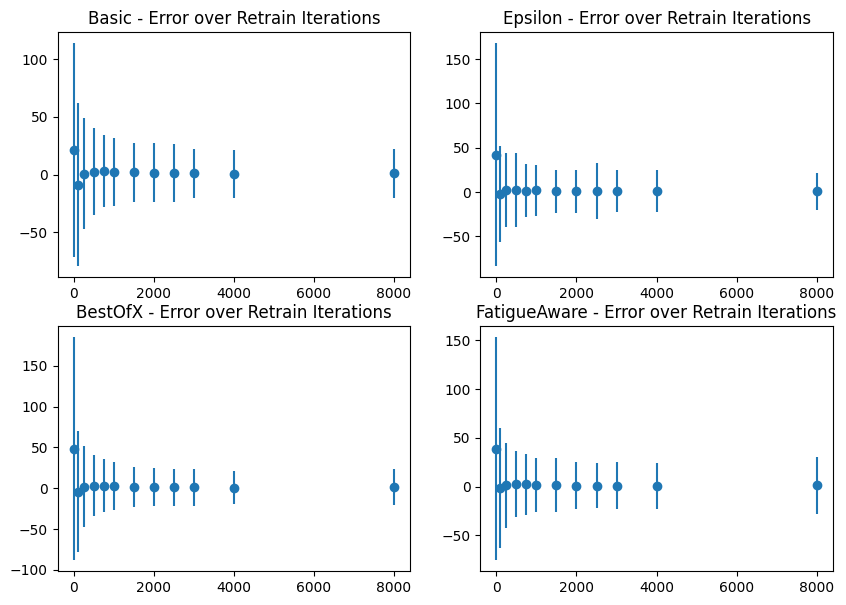

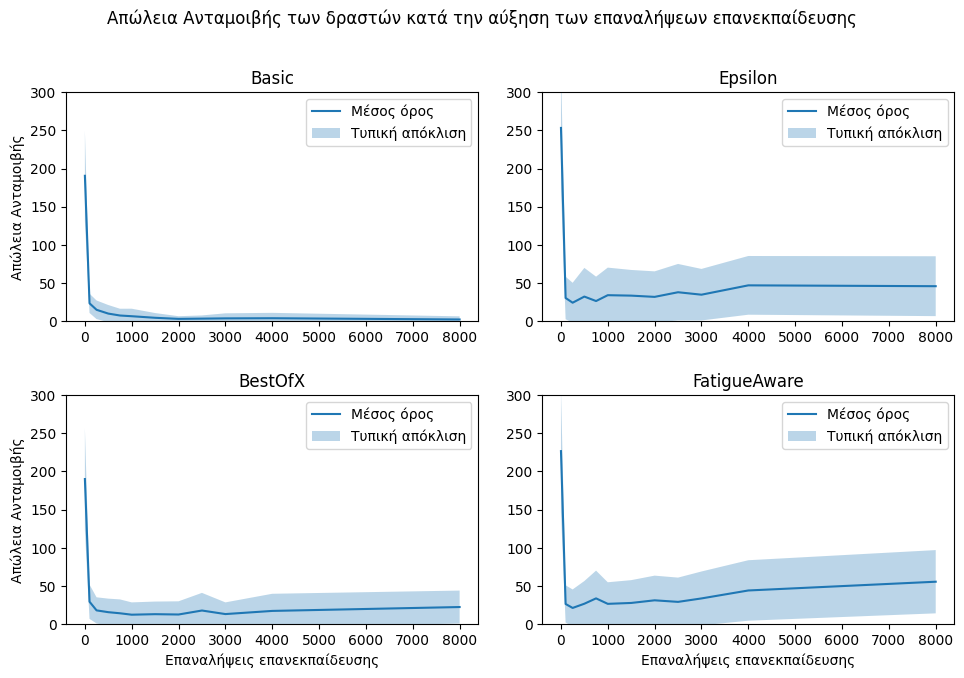

In [208]:
i=1
for name,agent in agents.items():
    plt.figure(1)
    plt.subplot(2,2,i)
    plt.errorbar(test_range,accs[name]['avg'],accs[name]['std'],marker='o',capsize=1)
    plt.fill_between(test_range,np.array(accs[name]['avg'])-np.array(accs[name]['std']),np.array(accs[name]['avg'])+np.array(accs[name]['std']),alpha=0.3)
    plt.tight_layout(pad=2)
    plt.ylim(0,1)
    if i in [1,3]:
        plt.ylabel('Ακρίβεια')
    if i in [3,4]:
        plt.xlabel('Επαναλήψεις επανεκπαίδευσης')
    plt.title("{}".format(name))
    plt.suptitle("Ακρίβεια δραστών κατά την αύξηση των επαναλήψεων επανεκπαίδευσης")
    plt.figure(2)
    plt.subplot(2,2,i)
    plt.errorbar(test_range,a_e[name]['avg'],a_e[name]['std'],marker='o',linestyle='')
    plt.title("{} - Error over Retrain Iterations".format(name))
    plt.figure(3)
    plt.subplot(2,2,i)
    y=np.array(d_b[name]['avg'])
    y_error=np.array(d_b[name]['std'])
    plt.plot(test_range,y,label='Μέσος όρος')
    plt.fill_between(test_range,y-y_error/2,y+y_error/2,alpha=0.3,label='Τυπική απόκλιση')
    plt.legend()
    plt.title("{}".format(name))
    plt.tight_layout(pad=2)
    plt.ylim(0,300)
    if i in [1,3]:
        plt.ylabel('Απώλεια Ανταμοιβής')
    if i in [3,4]:
        plt.xlabel('Επαναλήψεις επανεκπαίδευσης')
    plt.suptitle("Απώλεια Ανταμοιβής των δραστών κατά την αύξηση των επαναλήψεων επανεκπαίδευσης")
    i+=1